# SkimLit

NLP model to make reading medical abstracts easier.

To do this, we will implement the deep learning model described in https://arxiv.org/pdf/1612.05251.pdf

Project done on Google Colab (Tesla T4)

## Import required libraries

In [1]:
import os
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

## Get the data

The data is publicly available on GitHub so let's download it.

In [2]:
download_data = False
if download_data:
    !git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt   test.txt  train.txt


In order to have shorter compute times, we will use the PubMed_20k_RCT dataset, which is a subset (10%) of the original dataset.

In [4]:
# Let's work on the smaller dataset (20k instead of 200k)
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess the data

For the deep learning model to run, we will need to transform text into numbers. Hovewer, before this preprocessing step, let's see what the data look like.

In [6]:
# Function to read text
def get_lines(filename):
    """
    Reads filename and returns the lines as a list.

    Args:
    filename: path to text file.

    Returns:
    A list of strings with one string per line.
    """
    with open(filename, "r") as ifs:
        return ifs.readlines()

In [7]:
# Read train file
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

We need to separate the target labels (BACKGROUND, OBJECTIVE, etc.) from the text.

In [8]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries containing abstract data.
    """
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"): # The id of the abstract
            abstract_id = line
            abstract_lines = ""
        elif line.isspace(): # On a new line?
            abstract_lines_split = abstract_lines.splitlines()
            for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_lines_split) - 1
                # Append dictionary
                abstract_samples.append(line_data)
        else:
            abstract_lines += line

    return abstract_samples

In [9]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

In [10]:
train_samples[:2]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11}]

We can now turn these lists of dictionaries into dataframes.

In [11]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [12]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


We can now have a look at the distributions of training labels and abstract length.

In [13]:
# Distribution of labels in the training set
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

METHODS is the most common, while OBJECTIVE the least common.

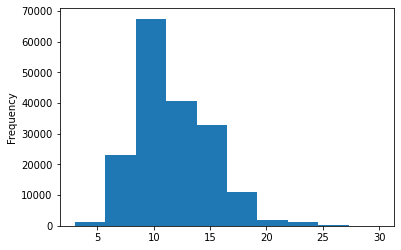

In [14]:
# Distribution of line lengths
train_df["total_lines"].plot.hist();

It looks like the majority of abstracts is between 6 to 15 sentences.

Finally, for building our model, it will be useful to have the columns of our dataframes as lists.

In [15]:
# Convert the dataframe columns into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [16]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Prepare numeric labels

We will use both one-hot encoding and label encoding. One-hot encoding is required when using CategoricalCrossentropy as loss function.

In [17]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [18]:
# Label encode
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [19]:
# Check one-hot-encoded labels
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
# Check label-encoded labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
# Get class names back from labels
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Prepare for deep learning

The model will have three components:

1. A token-level model.
2. A character-level model.
3. Two positional models: the first one for the line number within the abstract and the second one for the total number of lines in the abstract.

### Token-level layer

For the token-level model, we will use a pretrained embedding layer (the Universal Sentence Encoder, or USE) available at https://tfhub.dev/google/universal-sentence-encoder/4.

NOTE: The USE takes care of the tokenization for us.

In [37]:
# Download pretrained TensorFlow Hub Universal Sentence Encoder (USE)
# NOTE: this is ~1Gb and takes a while to download
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

### Character-level layer

For the character level model we first need to split the sentences into characters.

In [22]:
# Define function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

In [23]:
# Apply function to entire dataset
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:10]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [24]:
# Average character length
char_lens = [len(sentence) for sentence in train_sentences]
np.mean(char_lens)

149.3662574983337

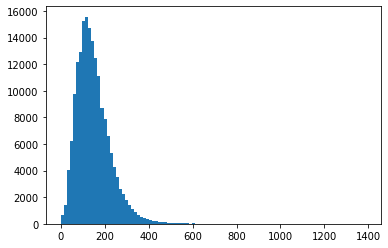

In [25]:
plt.hist(char_lens, bins=100);

In [26]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [27]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

We can now create the character-level vectorizer and adapt it to our training set:

In [28]:
# OOV = out of vocabulary (i.e. unkwown)
# Create char-level token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [29]:
# Adapt character vectorizer to training set (characters)
char_vectorizer.adapt(train_chars)

In [30]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters: {len(char_vocab)}")

Number of different characters: 28


Finally, we can create the character-level embedding layer:

In [31]:
# Create character-level embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25, # From paper
                              mask_zero=True,
                              name="char_embed")

### Positional Embeddings

For the last two components of the model, we will need the line number and the total number of lines.

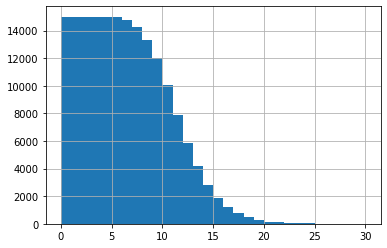

In [35]:
# Let's look at distribution of line_number
train_df["line_number"].hist(bins=30);

The majority of the lines have a position < 15. So we will use 15 as the depth parameter when one-hot encoding.

In [36]:
# Use Tensorflow to one-hot encode line_number
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:5]

<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

We can repeat the previous steps for the total number of lines:

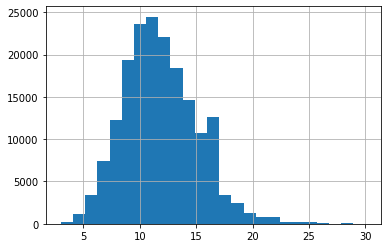

In [37]:
# Let's look at distribution of total_lines
train_df["total_lines"].hist(bins=25);

A value of 20 seems to cover the majority of samples. Let's use this value when one-hot encoding.

In [38]:
# Use Tensorflow to one-hot encode total_lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

## Building the model

We have now all the building blocks to define the final model:

In [52]:
# 1. Create a token-level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
# NOTE: token_outputs doesn't seem to be used!
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_embeddings)
                            #  outputs=token_outputs)

# 2. Create a character-level model
char_inputs = layers.Input(shape=(1, ), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Create model for line_number
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_outputs)

# 4. Create model for total_lines
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_outputs)

# 5. Combine 1 and 2
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine 3, 4, and 5
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_lines_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(z)

# 8. Combine inputs from 1, 2, 3, 4 and outputs of 7 into final model
model = tf.keras.Model(inputs=[line_number_model.input,
                               total_lines_model.input,
                               token_model.input,
                               char_model.input],
                       outputs=output_layer)

In [53]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_embed (Embedding)          (None, 290, 25)      1750        char_vectorizer[0][0]            
____________________________________________________________________________________________

Let's visualize the final model:

In [55]:
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [56]:
# Compile model (label smoothing helps prevent overfitting)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [57]:
# Create datasets
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [58]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [61]:
train = False
if train:
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3,
                                                  restore_best_weights=True,
                                                  verbose=0)
    # NOTE: need to train on whole dataset (not 10%), but this fails with early_stop
    # Stopped at epoch 20 (about 1h30)
    history_model = model.fit(train_char_token_pos_dataset,
                              epochs=100, # Bump up to 100 when using early stop
                              # steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              callbacks=[early_stop],
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))
    
    model.evaluate(val_char_token_pos_dataset)

    model_pred_probs = model.predict(val_char_token_pos_dataset)
    model_preds = tf.argmax(model_pred_probs, axis=1)

    res = pd.DataFrame({"preds": model_preds.numpy(), "truth": val_labels_encoded})
    res.to_csv("results/preds.csv", index=False)
else:
    res = pd.read_csv("results/preds.csv")

## Assessing model performance

In [62]:
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [64]:
model_results = calculate_results(y_true=res["truth"],
                                  y_pred=res["preds"])
model_results

{'accuracy': 87.18390043691248,
 'precision': 0.8722665244496874,
 'recall': 0.8718390043691249,
 'f1': 0.8691866359586281}

,preds,truth
0,0,0
1,0,0
2,0,3
3,2,2
4,2,2
...,...,...
30207,4,4
30208,4,4
30209,4,4
30210,4,1
